# Lab 3 — clustering

In [112]:
# Data imports
import json
import numpy as np
import pickle
import pandas as pd
from operator import itemgetter

# Models imports
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import random
from packaging.version import parse as parse_version
from scipy import __version__ as scipy_version

# Graph imports
import matplotlib.pyplot as plt
from bokeh.plotting import figure, gridplot, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
from bokeh.palettes import Dark2_8
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column, row

%matplotlib inline
plt.style.use("ggplot")

### Exercise 3.12

In [113]:
# Load data
def load_csv(path):
    df = pd.read_csv(path, header=None)
    cols = [1, 2, 3, 4, 5]
    df_selected = df.loc[:, cols]

    list_of_lists = df_selected.values.tolist()
    return df, df_selected, list_of_lists

df, df_selected, list_of_lists = load_csv('separated.csv')

In [114]:
# Visualize clustering output
output_notebook()

def create_visualization(train_X, n_clusters, df, directions =[1, 2], plot_width =720, plot_height = 480, display=False):
    
    # Standarize samples
    train_X = StandardScaler().fit_transform(train_X)
    
    plots = []
    for c in n_clusters:        
        
        # Kmeans clustering
        kmeans = KMeans(n_clusters = c, random_state=0).fit_predict(train_X)
        silhouette = silhouette_score(train_X, kmeans)
        
        # Choose principle direction to display samples
        source = ColumnDataSource(
        data={
            "x": list(df[directions[0]]),
            "y": list(df[directions[1]]),
            "tagnames": list(df[0]),
            "color": [Dark2_8[i] for i in kmeans],
            })

        # Plotting 
        hover = HoverTool(
            tooltips=[
                ("Tag Name", "@tagnames"),
            ])
        tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

        p = figure(plot_width=plot_width, plot_height=plot_height, tools=tools, 
                   title=f"k = {c}, directions = {directions}, Silhouette score: {silhouette}")
 
        p.circle("x", "y", source=source, size=10, color="color", alpha=0.5) 
        plots.append(p)
        
    layout = column(row(plots[:len(n_clusters)//2]), row(plots[len(n_clusters)//2:]))
    
    # Display graphs only if display is set to True
    if display:
        show(layout, notebook_handle=True)
    return layout
    
n_clusters = np.arange(2,8)
create_visualization(list_of_lists, n_clusters, df = df, display=True)

Loading BokehJS ...

Column(id='2691', ...)

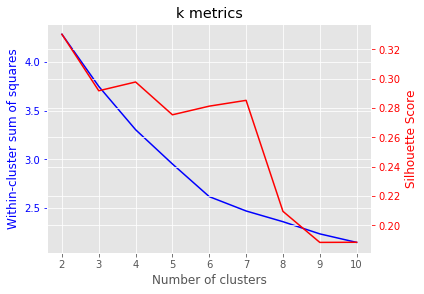

In [115]:
# Choose k which separates clusters the best
def best_k_elbow(train_X, n_clusters):
    
    # Elbows scores
    wss = []
    
    # Silhouettes score
    silhouettes = []
    
    for c in n_clusters: 
        
        # Perform Kmeans
        kmeans = KMeans(n_clusters = c, random_state=0).fit(train_X)
        wss.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(train_X, kmeans.labels_))

    # Plotting
    fig, ax1 = plt.subplots()

    ax1.plot(n_clusters, wss, 'b-')
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Within-cluster sum of squares', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    ax2.plot(n_clusters, silhouettes, 'r-')
    ax2.set_ylabel('Silhouette Score', color='r')
    ax2.tick_params('y', colors='r')

    fig.tight_layout()
    plt.title('k metrics')
    plt.show()
    
n_clusters = np.arange(2,11)
best_k_elbow(list_of_lists, n_clusters)

##### The best clustering we obtained for k = 6
- According to elbow method we can assume that k = 6 is the best value of k, however silhouette score fluctuates in this range of values. Maximum value of silhouette score is observated for 2, so metrics do not agree at this point.
- So we should observe output of model and see which k works better in our case.
- After analysing bokeh plots, choosing ***k = 6*** seems to be more accurate approach, as data should be clustered in more than 2 groups.

In [116]:
# Projecting on different principal directions
def compare_dir_proj(list_of_lists, n_clusters, df, directions, plot_width = 560, plot_height = 280):
    plots = []
    for d in directions:
        
        # Perform clustering and metrics calculation
        p = create_visualization(list_of_lists, n_clusters, df = df, directions=d, plot_width=plot_width, plot_height=plot_height)
        plots.append(p)
    
    # Plotting
    layout = column(row(plots))
    show(layout, notebook_handle=True)
    
directions = [[1,2], [2,3], [3,4], [4,5], [1,5]]
n_clusters = [2, 6]
compare_dir_proj(list_of_lists, n_clusters, df, directions)    

##### Which principal directions separate the clusters well?
- Data are separated in most clearly for ***principal directions = [1,2] and [1,5]***, which can be observed in graphs above.
- We assume that value of k is fixed, and it was chosen before.

### Exercise 3.13

In [121]:
# Load data
def load_txt(path):
    movies_sc = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
    movies_genres = dict(movies_sc.map(itemgetter("movieId", "genres")).collect())
    
    for i in movies_genres:
        movies_genres[i] = set(movies_genres[i])
    return movies_sc, movies_genres

movies_sc, movies = load_txt("/ix/ml-20m/movies.txt")[0], load_txt("/ix/ml-20m/movies.txt")[1]

In [122]:
# Jaccard distancegenres = movies.flatMap(lambda x: x['genres']).distinct().collect()
def jaccard_distance(movies, first_id, second_id):
    first_seq = movies[first_id]
    second_seq = movies[second_id]
    return 1 - len(first_seq & second_seq) / len(first_seq |second_seq)

def calc_jdistances(movies, center, samples):
    return [jaccard_distance(movies, center, sample) for sample in samples]

In [81]:
# Kmedioids algorithm

def kmedioids_alg(movies, movies_genres, n_clusters, max_iter=10, use_convergance=False):
    
    # Random initialization of centers
    centers = random.sample(list(movies), n_clusters)
    
    for i in range(max_iter):
        old_centers = centers.copy()
        clusters = [[] for cluster in range(n_clusters)]
        
        # Assign points to clusters
        for movie_id in movies:
            ind = int(np.argmin(calc_jdistances(movies_genres, movie_id, centers)))
            clusters[ind].append(movie_id)
            
        # Update the centers
        for c in range(n_clusters):      
            # Calculate the sum over jaccard distances according to new center
            min_sum = sum(calc_jdistances(movies_genres, centers[c], clusters[c]))
            
            # Choose random sample and set it as a new medioid
            #is_swaped = False
            #while not is_swaped:
            temp = random.choice(clusters[c])

            # Check if sum over distances is smaller then 
            temp_sum = sum(calc_jdistances(movies_genres, temp, clusters[c]))
            #for temp in clusters[c]:
            if temp_sum < min_sum:
                centers[c] = temp
                    #is_swaped = True
            
        if np.allclose(centers, old_centers, rtol=1e-3, atol=1e-3) and use_convergance:
            break

        print("centers after iter {}{}:".format(i, centers))
    return [movie_id for movie_id in movies if movie_id in clusters[0]], [movie_id for movie_id in movies if movie_id in clusters[1]]

In [123]:
# Implemtation of kmedioids algorithm
def kmedioids_alg(movies_ids, movies_genres, n_clusters, max_iter=10, use_convergance=False):
    # Random initialization of centers
    centers = random.sample(list(movies_ids), n_clusters)
    
    for i in range(max_iter):
        old_centers = centers.copy()
        clusters = [[] for cluster in range(n_clusters)]
        
        # Assign points to clusters
        for movie_id in movies_ids:
            ind = int(np.argmin([jaccard_distance(movies_genres, movie_id, center) for center in centers]))
            clusters[ind].append(movie_id)
            
        # Update the centers
        for c in range(n_clusters):
            cluster_movies = clusters[c]
            n_movies = len(cluster_movies)
            min_cost = np.inf
            min_center = None
            
            # Minimize jaccard_distance between clusters and other samples in dataset
            for m in range(n_movies):
                
                # Calculate the sum over jaccard distances according to new center
                cost = sum([jaccard_distance(movies_genres, cluster_movies[m], cluster_movies[j]) for j in range(n_movies)])
                min_cost, min_center = (cost, cluster_movies[m]) if cost < min_cost else (min_cost, min_center)
            
            # Update centroid
            centers[c] = min_center
        
        # Check convergance
        if np.allclose(centers, old_centers, rtol=1e-3, atol=1e-3) and use_convergance:
            break
            
        print(f"Centers after iter {i}, centers: {centers}")    
    return clusters

def get_clusters_movies_ids(movies_ids, clusters):
    return [movie_id for movie_id in movies_ids if movie_id in clusters[0]], [movie_id for movie_id in movies_ids if movie_id in clusters[1]]

In [120]:
# Perform clustering on file most-rated.pickle
def load_pickle(path):
    with open(path, "rb") as f:
        most_rated = pickle.load(f, encoding="utf-8")
    most_rated_ids = [x[0] for x in most_rated]
    return most_rated_ids

most_rated_ids = load_pickle("most-rated.pickle")
clusters = kmedioids_alg(most_rated_ids, movies, n_clusters = 2)#, use_convergance = True)

Centers after iter 0, centers: [2858, 2571]
Centers after iter 1, centers: [2858, 480]
Centers after iter 2, centers: [2858, 480]
Centers after iter 3, centers: [2858, 480]
Centers after iter 4, centers: [2858, 480]
Centers after iter 5, centers: [2858, 480]
Centers after iter 6, centers: [2858, 480]
Centers after iter 7, centers: [2858, 480]
Centers after iter 8, centers: [2858, 480]
Centers after iter 9, centers: [2858, 480]


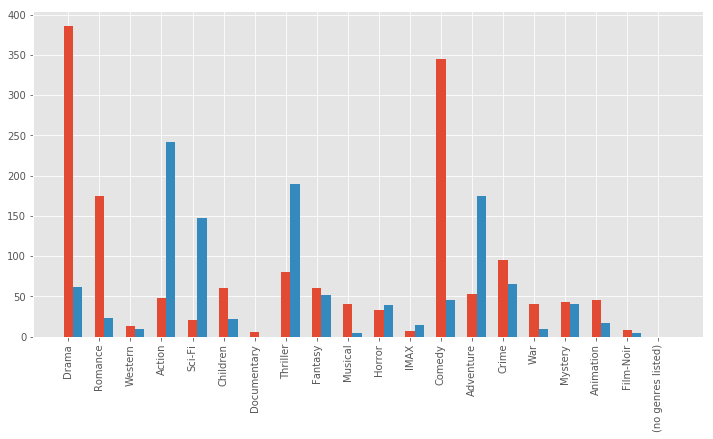

In [124]:
# Store data about movies genres according to clusters classification 
def assign_genres(movies, clusters):
    cluster_0 = {}
    cluster_1 = {}
    for genre in unique_genres:
        cluster_0[genre] = len([1 for movie_id in clusters[0] if genre in movies[movie_id]])
        cluster_1[genre] = len([1 for movie_id in clusters[1] if genre in movies[movie_id]])
    
    return cluster_0, cluster_1

# Visualization of frequencies of genres 
def create_viz(movies, clusters, unique_genres):
    
    # Get movies in clusters
    cluster_0, cluster_1 = assign_genres(movies, clusters)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(0, len(list(cluster_0.values()))), list(cluster_0.values()), width = 0.3)
    plt.bar(np.arange(0.3, len(list(cluster_1.values())) + 0.3), list(cluster_1.values()), width = 0.3)
    plt.xticks(range(len(unique_genres)), unique_genres, rotation = 90)
    plt.show()
    
unique_genres = movies_sc.flatMap(lambda x: x['genres']).distinct().collect()
clusters = get_clusters_movies_ids(most_rated_ids, clusters)
create_viz(movies, clusters, unique_genres)

In [126]:
# Find most common genres in clusters
def the_most_common_genres(movies, clusters, how_many = 5):
    
    # Get movies in clusters
    clusters = assign_genres(movies, clusters)
    tops = []
    
    for id, cluster in enumerate(clusters):
        # Sort the dictionary items by their values in descending order
        sorted_items = sorted(cluster.items(), key=lambda x: x[1], reverse=True)

        # Get the top keys with the biggest values
        top_keys = [item[0] for item in sorted_items[:how_many]]
        tops.append(top_keys)
    
        print(f'5 most common genres in {id} cluster: \n{tops[id]}')
    
the_most_common_genres(movies, clusters)

5 most common genres in 0 cluster: 
['Drama', 'Comedy', 'Romance', 'Crime', 'Thriller']
5 most common genres in 1 cluster: 
['Action', 'Thriller', 'Adventure', 'Sci-Fi', 'Crime']


##### How do you interpret the two clusters?
- Interpretation of results is problematic, as clusters share different genres with each other. Even in most common genres, *Crime* belongs to both clusters. So genres clusters are not exlusive.
- However it is noticable that in blue cluster, movies are linked with high dynamic notion (*Action*, *Thriller*, *Sci-fi*, *Adventure*). Is intuitvely true, as in real world there are a lot of movies which share this genres. Not all of these movies are dedicated for children, which this graph seems to also reflects.
- On the other hand we have red cluster, in which the biggest category is *Comedy*, *Drama* and *Romance*. Those movies can be watched by universal users. The topics of movies are more spread than in previous cluster. 
- *Documentaries* are not in red cluster at all, so they seem to be most far from topics shared in previous cluster. *IMAX* movies are the opposite, they are rarely observable in red cluster.  
- Following my reasoning on splitting movies we can assume that age groups are also decisive factors similar to general topic covered by movie.